In [17]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from pandas import Index
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from pytrends import request
import pickle

In [80]:
def signal_process(table,event_var='PM25_Marseille_Longchamp',event_threshold = 40, duration = 6,var_name_list='air pollution'):
    """Find the spike in pm25 and plot a sliding window for google trend """

    index_list=np.where(table[event_var]>event_threshold)[0]
    
    # add first element
    shrink_index_list = [index_list[0]]
    date_set ={table.datetime[index_list[0]]}
    
    # exclude for the same day
    for cnt in range(1,len(index_list)):
        if table.datetime[index_list[cnt]] in date_set:
            pass
        else:
            shrink_index_list.append(index_list[cnt].copy())
            date_set.add(table.datetime[index_list[cnt]])
    
    bind_list = []
    for start_index in shrink_index_list:
        this_sequence = table.loc[range(start_index-2,start_index+duration),
                                  var_name_list]
        start_date = table.datetime[start_index]
        tuples = list(zip([start_date]*(duration+2),range(-2,duration)))

        this_sequence.index = pd.MultiIndex.from_tuples(tuples,names=['event_date_index','hour_index'])
    #         this_sequence = (this_sequence- this_sequence.mean())/this_sequence.std()

        bind_list.append(this_sequence)
    new_table=pd.concat(bind_list)     
    
    return new_table

In [18]:
def fetching_trend(airdata, kw_list,location_code='FR-U',timezone = 0):
    input_table = airdata
    newest_datetime   = max(input_table['datetime'])
    earliest_datetime = min(input_table['datetime'])
    pytrends = TrendReq(hl='En-US', tz=timezone)
    print("fectching trend ")
    ggtrend_list =[]
    for keyword in kw_list:
        
        this_list = [keyword]
        try: 
            topic_code = pytrends.suggestions(keyword)[0]['mid']
            this_list.append(topic_code)
        except IndexError:
            pass
            
        ggtrend = pytrends.get_historical_interest(this_list, 
                                 year_start=earliest_datetime.year,
                                          month_start=earliest_datetime.month, 
                                          day_start=earliest_datetime.days_in_month, 
                                          hour_start=earliest_datetime.hour, 
                                 year_end=newest_datetime.year,
                                          month_end=newest_datetime.month, 
                                          day_end=newest_datetime.days_in_month, 
                                          hour_end=newest_datetime.hour, 
                                 cat=0, # all categorical
                                          geo=location_code,  # Provence-Alpes-Côte d'Azur
                                          gprop='',  # no specific group # image #hastag etc
                                          sleep=0)
        if len(this_list)==2: 
            ggtrend.columns= Index([keyword, keyword+" topic", 'isPartial'], dtype='object')
        ggtrend_list.append(ggtrend)
    print("trend is fectched")
    return ggtrend_list

In [4]:
# loading table 

In [5]:
parca_table= pd.read_csv("../stage/parif.csv")

In [6]:
parca_table['datetime']=parca_table['datetime'].apply(lambda string: datetime.strptime(string,'%Y-%m-%d %H:%M:%S'))

In [7]:
full_date_time = pd.date_range(parca_table[['datetime']].min()[0],parca_table[['datetime']].max()[0],freq='H')
full_time_set = set(map(lambda mytime: mytime.strftime("%Y-%m-%d %H:%M:%S"),full_date_time.to_series())) 
data_time_set = set(map(lambda timestamp: str(timestamp),parca_table['datetime']))
    # pad na values
if len(full_time_set) != len(data_time_set):
    pad_time = full_time_set -data_time_set
    pad_table = pd.DataFrame()
    pad_table['datetime']=[datetime.strptime(mytime,"%Y-%m-%d %H:%M:%S") for mytime in pad_time]
    for column in parca_table.columns:
        if column !="datetime":
            pad_table[column]=None
    parca_table = pd.concat([parca_table,pad_table],ignore_index=True)

In [8]:
# fetching google trend

In [9]:
full_date_time

DatetimeIndex(['2017-01-01 00:00:00', '2017-01-01 01:00:00',
               '2017-01-01 02:00:00', '2017-01-01 03:00:00',
               '2017-01-01 04:00:00', '2017-01-01 05:00:00',
               '2017-01-01 06:00:00', '2017-01-01 07:00:00',
               '2017-01-01 08:00:00', '2017-01-01 09:00:00',
               ...
               '2018-08-18 14:00:00', '2018-08-18 15:00:00',
               '2018-08-18 16:00:00', '2018-08-18 17:00:00',
               '2018-08-18 18:00:00', '2018-08-18 19:00:00',
               '2018-08-18 20:00:00', '2018-08-18 21:00:00',
               '2018-08-18 22:00:00', '2018-08-18 23:00:00'],
              dtype='datetime64[ns]', length=14280, freq='H')

In [20]:
KW_LIST= ['asthme',
#           'difficulté à respirer',
#           'difficultés respiratoires',
#           'difficulté pour respirer',
#           'sensation d’étouffement',
          'dyspnée',
#           'spasmophilie',
#           'nuage de pollution',
#           'saleté de l’air',
#           'particules nocives',
          'respiration',
#           'maladies respiratoires',
          'pollution de l’air',
#           'pollution atmosphérique',
#           'pollution',
          'Masque', #mask
          "Purificateur d'air", #air purifier
         ]

In [21]:
LOCATION_CODE = 'FR-J'  # for Île-de-France

In [22]:
ggtrend_list = fetching_trend(parca_table,kw_list=KW_LIST,location_code=LOCATION_CODE,timezone = 0)


fectching trend 
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 429.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with code 500.
The request failed: Google returned a response with c

ValueError: Shape of passed values is (18, 14519), indices imply (18, 14020)

In [54]:
for ggtrend in ggtrend_list:
    print (ggtrend.shape)
    print(ggtrend.head())

(13681, 3)
                     asthme  asthme topic isPartial
date                                               
2017-01-31 00:00:00      43            65     False
2017-01-31 01:00:00      23            38     False
2017-01-31 02:00:00      11            45     False
2017-01-31 03:00:00      52            65     False
2017-01-31 04:00:00      10            20     False
(12667, 3)
                     dyspnée  dyspnée topic isPartial
date                                                 
2017-01-31 00:00:00       17             17     False
2017-01-31 01:00:00       15             15     False
2017-01-31 02:00:00        0             22     False
2017-01-31 03:00:00        0            100     False
2017-01-31 04:00:00        0             57     False
(13681, 3)
                     respiration  respiration topic isPartial
date                                                         
2017-01-31 00:00:00           25                 71     False
2017-01-31 01:00:00           17       

In [68]:
mydata = ggtrend_list[0].reset_index()

In [69]:
for i in range(1,6):
    mydata=mydata.merge(ggtrend_list[i].reset_index(),on='date',how='outer')

In [71]:
ggtrend=mydata

In [77]:
ggtrend.drop(columns=['isPartial_x','isPartial_y'],inplace=True)

In [78]:
merged_t=parca_table.merge(ggtrend,left_on='datetime',right_on='date',how='outer')
kw_str  ="_".join(KW_LIST)
merged_t.to_csv("../stage/parif_{}_{}.csv".format(kw_str,parca_table.columns[1]))

In [81]:
merged_t.head()

,PA04C_PM25,PA04C_PM10,PA04C_O3,PA04C_NO2,PA04C_CO,datetime,date,asthme,asthme topic,dyspnée,dyspnée topic,respiration,respiration topic,pollution de l’air,pollution de l’air topic,Masque,Masque topic,Purificateur d'air,Purificateur d'air topic
0,27.0,29.0,12.0,29.0,400.0,2017-01-01 00:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28.0,31.0,9.0,36.0,400.0,2017-01-01 01:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28.0,28.0,8.0,37.0,400.0,2017-01-01 02:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21.0,24.0,11.0,29.0,400.0,2017-01-01 03:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17.0,17.0,12.0,28.0,300.0,2017-01-01 04:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
signal_table=signal_process(merged_t,event_var='PA04C_PM25',event_threshold = 35,duration = 12,var_name_list=list(ggtrend.columns)+['PA04C_PM25'])

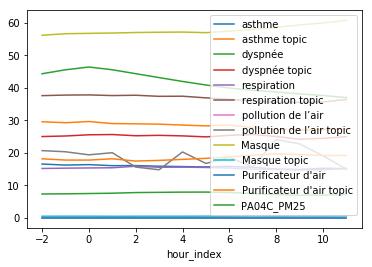

In [83]:
signal_table.groupby("hour_index").mean().plot()

In [84]:
signal_table.to_csv("../output/air_parif_threshold_35_colsum_duration_12H.csv")